## Neural Machine Translation

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

### Load Data

In [2]:
english_corpus_path = 'fr-en/europarl-v7.fr-en.en'
french_corpus_path = 'fr-en/europarl-v7.fr-en.fr'

In [3]:
english_corpus = []
french_corpus = []

In [4]:
with open(english_corpus_path, encoding='utf-8', mode='r') as f:
    english_corpus = f.readlines()

In [5]:
with open(french_corpus_path, encoding='utf-8', mode='r') as f:
    french_corpus = f.readlines()

In [6]:
english_corpus[10]

"Would it be appropriate for you, Madam President, to write a letter to the Sri Lankan President expressing Parliament's regret at his and the other violent deaths in Sri Lanka and urging her to do everything she possibly can to seek a peaceful reconciliation to a very difficult situation?\n"

In [7]:
french_corpus[10]

"Ne pensez-vous pas, Madame la Présidente, qu'il conviendrait d'écrire une lettre au président du Sri Lanka pour lui communiquer que le Parlement déplore les morts violentes, dont celle de M. Ponnambalam, et pour l'inviter instamment à faire tout ce qui est en son pouvoir pour chercher une réconciliation pacifique et mettre un terme à cette situation particulièrement difficile.\n"

### Make Dictionary

In [8]:
def tokenize(sentence):
    return sentence.split()

In [9]:
english_corpus = [tokenize(x) for x in english_corpus]
french_corpus = [tokenize(x) for x in french_corpus]

In [10]:
from collections import Counter

def make_dict(corpus, *, unk_word_cutoff_freq=10):
    vocab = Counter()
    for sentence in corpus:
        vocab.update(sentence)
    sorted_words = ['_'] + sorted([word for word in vocab.keys() 
                                   if vocab[word] > unk_word_cutoff_freq])
    index_to_word = dict(enumerate(sorted_words))
    word_to_index = dict((v, k) for k,v in index_to_word.items())
    vocab_size = len(index_to_word)
    index_to_word[vocab_size] = 'UNK'
    word_to_index['UNK'] = vocab_size
    
    return index_to_word, word_to_index

In [11]:
en_index_to_word, en_word_to_index = make_dict(english_corpus)
fr_index_to_word, fr_word_to_index = make_dict(french_corpus)

In [12]:
len(en_word_to_index)

56918

In [13]:
len(fr_word_to_index)

76466

### Filter Sentence By Length

In [14]:
def filter_by_length(source_corpus, target_corpus, maximum_length):
    filtered_source_corpus = []
    filtered_target_corpus = []
    for idx, sentence in enumerate(source_corpus):
        if (len(source_corpus[idx]) <= maximum_length) and \
            (len(target_corpus[idx]) <= maximum_length):
            filtered_source_corpus.append(source_corpus[idx])
            filtered_target_corpus.append(target_corpus[idx])
    return filtered_source_corpus, filtered_target_corpus

#### Sentence Length Distribution

#### English

(array([ 232428.,  596458.,  553040.,  331362.,  162182.,   73441.,
          32086.,   14210.,    6266.,    3004.]),
 array([  0. ,   9.9,  19.8,  29.7,  39.6,  49.5,  59.4,  69.3,  79.2,
         89.1,  99. ]),
 <a list of 10 Patch objects>)

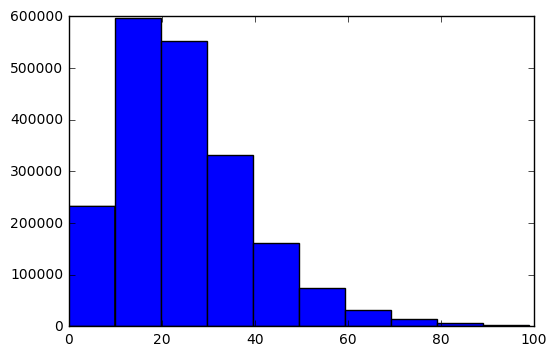

In [15]:
plt.hist([len(sentence) for sentence in english_corpus if len(sentence) < 100])

#### French

(array([ 222794.,  554107.,  540985.,  348875.,  181063.,   86625.,
          39249.,   17675.,    8117.,    3793.]),
 array([  0. ,   9.9,  19.8,  29.7,  39.6,  49.5,  59.4,  69.3,  79.2,
         89.1,  99. ]),
 <a list of 10 Patch objects>)

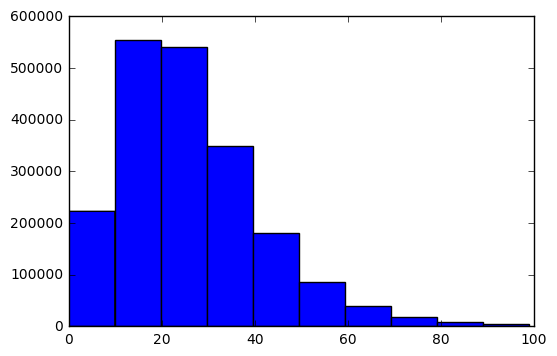

In [16]:
plt.hist([len(sentence) for sentence in french_corpus if len(sentence) < 100])

In [17]:
max_sentence_length = 10

In [18]:
english_corpus, french_corpus = filter_by_length(english_corpus, french_corpus, max_sentence_length)

In [19]:
len(english_corpus)

227475

In [20]:
len(french_corpus)

227475

### Encode Text to Index

In [21]:
def encode_corpus(corpus, word_to_index, max_sentence_length):
    
    def encode(sentence, word_to_index, max_sentence_length):
        encoded_sentence = []
        for word in sentence:
            if word in word_to_index.keys():
                encoded_sentence.append(word_to_index[word])
            else:
                encoded_sentence.append(word_to_index['UNK'])
        # Sentence Length == max_len
        encoded_sentence += [0] * (max_sentence_length - len(encoded_sentence))
        return encoded_sentence

    for idx, sentence in enumerate(corpus):
        corpus[idx] = encode(sentence, word_to_index, max_sentence_length)

In [22]:
encode_corpus(english_corpus, en_word_to_index, max_sentence_length)
encode_corpus(french_corpus, fr_word_to_index, max_sentence_length)

In [23]:
english_corpus[0]

[13110, 40569, 52574, 48862, 0, 0, 0, 0, 0, 0]

In [24]:
french_corpus[0]

[10813, 27919, 46469, 66935, 0, 0, 0, 0, 0, 0]

In [25]:
import tensorflow as tf
from tensorflow.python.framework import ops

In [26]:
ops.reset_default_graph()

In [27]:
train_batch_size = 64
val_batch_size = 32
embedding_dim = 256

In [28]:
encoder_inputs = [tf.placeholder(tf.int32, shape=(None,), name='encoder_input%i' %i) \
                     for i in range(max_sentence_length)]
labels = [tf.placeholder(tf.int32, shape=(None,), name='label%i' %i) \
             for i in range(max_sentence_length)]
decoder_inputs = [tf.zeros_like(encoder_inputs[0], dtype=tf.int32, name='GO')] + labels[:-1]

In [29]:
cell = tf.contrib.rnn.LSTMCell(embedding_dim)

In [30]:
seq2seq_config = {
    'encoder_inputs':encoder_inputs,
    'decoder_inputs':decoder_inputs,
    'cell':cell,
    'num_encoder_symbols':len(en_word_to_index),
    'num_decoder_symbols':len(fr_word_to_index),
    'embedding_size':embedding_dim
    }

In [31]:
with tf.variable_scope('decoder') as scope:
    decoder_outputs, _ = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(**seq2seq_config,
                                                                        feed_previous=False)
    scope.reuse_variables()
    decode_outputs_test, _ = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(**seq2seq_config,
                                                                            feed_previous=True)

In [32]:
loss_weights = [tf.ones_like(l, dtype=tf.float32) for l in labels]
loss = tf.contrib.legacy_seq2seq.sequence_loss(decoder_outputs, labels, loss_weights)
optimizer = tf.train.AdamOptimizer(1e-5)
train_op = optimizer.minimize(loss)

In [33]:
import numpy as np

In [34]:
class BatchGenerator:
    
    def __init__(self, X, Y, batch_size):
        assert len(X) == len(Y)
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.data_size = len(self.X)
        self.batch_size = batch_size
        self.iter = self.make_random_iter()
    
    def make_random_iter(self):
        splits = np.arange(self.batch_size, self.data_size, self.batch_size)
        it = np.split(np.random.permutation(range(self.data_size)), splits)[:-1]
        return iter(it)
    
    def next_batch(self):
        try:
            idxs = next(self.iter)
        except StopIteration:
            self.iter = self.make_random_iter()
            idxs = next(self.iter)
        inputs = self.X[idxs].T
        targets = self.Y[idxs].T
        return inputs, targets

In [35]:
num_instance = len(english_corpus)
print(num_instance)

227475


In [36]:
train_size = int(num_instance * 0.8)
print(train_size)

181980


In [37]:
train_inputs = english_corpus[:train_size]
train_targets = french_corpus[:train_size]
val_inputs = english_corpus[train_size:]
val_targets = french_corpus[train_size:]

In [38]:
train_iter = BatchGenerator(train_inputs, train_targets, train_batch_size)
val_iter = BatchGenerator(val_inputs, val_targets, val_batch_size)

In [39]:
def get_feed(inputs, targets):
    feed_dict = {encoder_inputs[t]: inputs[t] for t in range(max_sentence_length)}
    feed_dict.update({labels[t]: targets[t] for t in range(max_sentence_length)})
    return feed_dict

In [40]:
def print_as_text(inputs, outputs, targets, en_index_to_word, fr_index_to_word):
    num_print = 3
    inputs = inputs.T
    outputs = np.array(outputs).transpose([1,0,2])
    targets = targets.T
    
    for idx in range(num_print):
        input_text = ' '.join([en_index_to_word[i] for i in inputs[idx]])
        target_text = ' '.join([fr_index_to_word[i] for i in targets[idx]])
        predicted_text = ' '.join([fr_index_to_word[i] for i in np.argmax(outputs, axis=2)[idx]])
        print('Source: ', input_text)
        print('Target: ', target_text)
        print('Predict: ', predicted_text, '\n')

In [41]:
max_iteration = 300000
print_every = 2000

In [42]:
with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(max_iteration):
        try:
            train_input, train_target = train_iter.next_batch()
            sess.run(train_op, feed_dict=get_feed(train_input, train_target))
            
            if i % print_every == 0:
                train_loss_outputs = sess.run([loss] + decoder_outputs,
                                   feed_dict=get_feed(train_input, train_target))
                train_loss = train_loss_outputs[0]
                train_outputs = train_loss_outputs[1:]
                
                val_input, val_target = val_iter.next_batch()
                val_loss_outputs = sess.run([loss] + decode_outputs_test,
                                                 feed_dict=get_feed(val_input, val_target))
                val_loss = val_loss_outputs[0]
                val_outputs = val_loss_outputs[1:]
                
                print('>>>>>>>>>> iteration : {}'.format(i),'\n')
                print('Train Loss : {}'.format(train_loss),'\n')
                print_as_text(train_input, train_outputs, train_target, 
                              en_index_to_word, fr_index_to_word)
                print('\n')
                print('Validation Loss : {}'.format(val_loss),'\n')
                print_as_text(val_input, val_outputs, val_target,
                             en_index_to_word, fr_index_to_word)
                print('\n')
        
        except KeyboardInterrupt:
            print('Interrupted by user')
            break

>>>>>>>>>> iteration : 0 

Train Loss : 11.245753288269043 

Source:  . _ _ _ _ _ _ _ _ _
Target:  . _ _ _ _ _ _ _ _ _
Predict:  course compensent compensent compensent compensent compensent compensent compensent compensent compensent 

Source:  Europe needs a common foreign and defence policy. _ _
Target:  L’Europe a besoin d’une politique étrangère et de défense commune.
Predict:  persistant persistant persistant compensent compensent compensent compensent compensent compensent J’étais 

Source:  We have made a great deal of progress since 1999.
Target:  De nombreux progrès ont été réalisés depuis 1999. _ _
Predict:  Région d'ingénieurs répand défie défie allergies laitier, laitier, laitier, voeu 



Validation Loss : 11.246786117553711 

Source:  UNK _ _ _ _ _ _ _ _ _
Target:  Deuxième point. _ _ _ _ _ _ _ _
Predict:  61. compensent compensent compensent compensent compensent compensent compensent compensent compensent 

Source:  In paragraph 13 we mention consultants. _ _ _ _
Targe

##### hidden dimension size, cell type, #layer, attention, tokenizing, #unk, 